In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import sys
import os
cwd = os.getcwd()

# Armado de datos

Traemos los datos y definimos las clases de prendas

In [4]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

In [8]:
X_train = np.loadtxt(cwd + "/../datos/X_train.csv", delimiter=",")
y_train = np.loadtxt(cwd + "/../datos/y_train.csv", delimiter=",").astype(int)
X_test = np.loadtxt(cwd + "/../datos/X_test.csv", delimiter=",")
y_test = np.loadtxt(cwd + "/../datos/y_test.csv", delimiter=",").astype(int)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5000, 784), (5000,), (500, 784), (500,))

Muestras por clase y visualizacion de ejemplo

In [8]:
np.bincount(y_train), np.bincount(y_test)

(array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

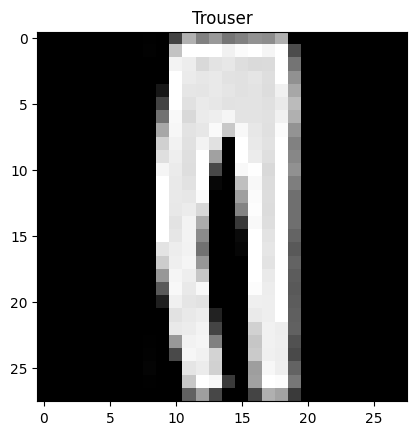

In [9]:
ix = 1
plt.imshow(X_test[ix].reshape(28,28), cmap="gray")
plt.title(class_names[y_test[ix]]);

Por ultimo separamos en datos de desarrollo.
Stratify garantiza que las clases estaran balanceadas

In [11]:
from sklearn.model_selection import train_test_split
X_newtrain, X_dev, y_newtrain, y_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

np.bincount(y_newtrain), np.bincount(y_dev)

(array([400, 400, 400, 400, 400, 400, 400, 400, 400, 400]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

# K-nearest neighbours

Desarrollamos la solucion sin usar numPy

In [11]:
def distance(A, B):
  return 1 - np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))

In [12]:
class Neighbour:
  def __init__(self, distance, clothesType, image):
    self.distance = distance
    self.image = image
    self.clothesType = clothesType

  def __lt__(self, other):
    return self.distance < other.distance


def kNearestNeighbourIterative(train, dev, k):
  # dev, train = (Prenda, vector)
  recognised = 0
  for A in dev:
      hood = []
      for B in train:
        distanceAB = distance(A.second, B.second)
        neighbour = Neighbour(distanceAB, A.first, A.second)
        hood.append(neighbour)

      hood.sort()

      types = []
      for i in range(0, k):
        types.append(hood[i].clothesType)

      # Calculamos la moda de types
      mode = st.mode(types)

      if mode == A.first:
        recognised += 1

  return recognised/len(train)

Hagamoslo usando numPy

In [13]:
def corr(X, Y):
    _X = X.copy()
    _Y = Y.copy()

    _X = _X - _X.mean(1).reshape(-1,1)
    _Y = _Y - _Y.mean(1).reshape(-1,1)

    _X = _X / np.linalg.norm(_X, axis = 1).reshape(-1,1)
    _Y = _Y / np.linalg.norm(_Y, axis = 1).reshape(-1,1)

    A = (_X @ _Y.T)
    return A

def Dist(X, Y):
    A = corr(X, Y)
    return 1 - A

In [14]:
#una distancia de ejemplo
D = np.diag([4, 5])
B = np.array([[1, 2],
            [3, 4]])

C = Dist(D, B)
print(C)

[[2.00000000e+00 2.00000000e+00]
 [2.22044605e-16 2.22044605e-16]]


In [14]:
def kNearestNeighbour(x_train, y_train, x_dev, y_dev, k):
    
    D = Dist(x_dev, x_train) # Matriz de distancias

    distOrd = np.argsort(D,axis = 1)
    distOrd = distOrd[:, :k]
    
    tipos = np.take(y_train, distOrd)

    modas = st.mode(tipos.T).mode
    
    return np.equal(modas, y_dev).mean()

In [15]:
#aca lo probamos
kNearestNeighbour(X_newtrain, y_newtrain, X_dev, y_dev, 5)

0.794

##Validacion cruzada

* Partir los datos en una partición de 5 partes manteniendo el mismo balance de clases en cada parte
* Iterar sobre estas partes, tomando 4 partes para entrenar y 1 para desarrollo de forma cíclia
* Medir la performance para cada parte
* Tomar el promedio

* Realizar la validación cruzada para distintos valores de $k$ de KNN, y encontrar el mejor

In [16]:
def crossValidationKnn(x_train, y_train, kMax):
  x_train_split = np.split(x_train, 5)
  y_train_split = np.split(y_train, 5)

  valueForKMap = {}

  for k in range(1, kMax+1):
    avg = 0 # acá vamos a guardar la suma de (aciertos/totales) para c/u de las divisiones entre train y dev
    for i in range(0, 5):
      x_partition_dev = x_train_split[i]
      y_partition_dev = y_train_split[i]

      x_partition_train = x_train_split.copy()
      x_partition_train.pop(i)
      x_partition_train = np.concatenate(x_partition_train)
      
      y_partition_train = y_train_split.copy()
      y_partition_train.pop(i)
      y_partition_train = np.concatenate(y_partition_train)
    
      avg += kNearestNeighbour(x_partition_train, y_partition_train, x_partition_dev, y_partition_dev, k)

    valueForKMap[k] = avg/5

  return valueForKMap


In [18]:
crossValidationKnn(X_train, y_train, 6)

{1: 0.8106,
 2: 0.8051999999999999,
 3: 0.8098000000000001,
 4: 0.813,
 5: 0.8030000000000002,
 6: 0.8086}

Vamos a probar la Crossed Validation explorando de k = 1 a 20 como hiperparametro

/tmp/ipykernel_615910/1154600550.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


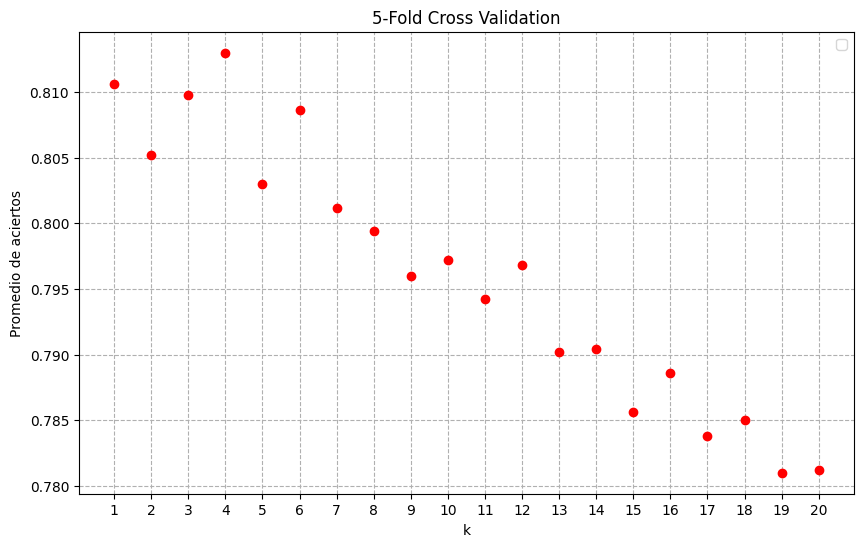

In [19]:
kValues = crossValidationKnn(X_train, y_train, 20)

plt.figure(figsize=(10, 6))
plt.plot(list(kValues.keys()), list(kValues.values()), "o", color='red')

plt.xlabel('k')
plt.xticks(range(1,len(kValues)+1))
plt.ylabel('Promedio de aciertos')

plt.title('5-Fold Cross Validation')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Metodo de la potencia

Calcula el autovector al autovalor asociado de valor máximo

Devuelve (a, v) con a autovalor, y v autovector de A

epsilon es la tolerancia

In [73]:
def power_iteration(A, niter=10_000, eps=1e-6):

    a = 1
    x = np.random.randn(A.shape[0])
    x = x / np.linalg.norm(x)

    i = 0
    dif = 1
    while i < niter or dif < eps:
      x = (A @ x) / np.linalg.norm(A @ x)
      i = i + 1

    a = (x.T @ A @ x) / (x.T @ x)

    return a, x

vamos a verificar la implementacion con la matriz de HouseHolder

In [74]:
D = np.diag([5.0, 4.0, 3.0, 2.0, 1.0])

v = np.ones((D.shape[0], 1))

v = v / np.linalg.norm(v)

B = np.eye(D.shape[0]) - 2 * (v @ v.T)

# Matriz a diagonalizar
M = B.T @ D @ B

power_iteration(M)

(5.000000000000001, array([-0.6,  0.4,  0.4,  0.4,  0.4]))

In [75]:
D = np.diag(np.linspace(1, 20, 5))
v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)
B = np.eye(D.shape[0]) - 2 * (v @ v.T)
M = B.T @ D @ B

power_iteration(M)

(20.000000000000004, array([-0.4, -0.4, -0.4, -0.4,  0.6]))

Metodo de potencia + deflacion

In [76]:
def eigen(A, num=2, niter=10000, eps=1e-6):
    A = A.copy()
    eigenvalues = []
    eigenvectors = []
    for i in range(num):
      a, v = power_iteration(A)
      eigenvalues.append(a)
      eigenvectors.append(v)
      A = A - a*(np.outer(v, v.T))

    return np.array(eigenvalues), eigenvectors

Verificamos

In [77]:
D = np.diag(range(10, 0, -1))

l, v = eigen(D,10)
print(l, v)

[10.  9.  8.  7.  6.  5.  4.  3.  2.  1.] [array([ 1.e+000, -2.e-323, -1.e-323,  5.e-324, -5.e-324,  0.e+000,
        0.e+000,  0.e+000,  0.e+000,  0.e+000]), array([-2.e-323, -1.e+000,  2.e-323,  1.e-323, -5.e-324, -5.e-324,
        0.e+000,  0.e+000,  0.e+000,  0.e+000]), array([-1.e-323, -2.e-323, -1.e+000, -2.e-323, -1.e-323,  5.e-324,
        0.e+000,  0.e+000,  0.e+000,  0.e+000]), array([-4.9e-324,  1.5e-323, -2.5e-323,  1.0e+000,  1.5e-323,  4.9e-324,
       -4.9e-324,  0.0e+000,  0.0e+000,  0.0e+000]), array([ 9.9e-324, -9.9e-324, -1.5e-323, -2.0e-323,  1.0e+000, -9.9e-324,
        4.9e-324,  0.0e+000,  0.0e+000,  0.0e+000]), array([ 0.e+000, -1.e-323,  1.e-323, -5.e-324,  1.e-323,  1.e+000,
        1.e-323,  5.e-324,  0.e+000,  0.e+000]), array([ 0.e+000,  0.e+000,  0.e+000, -1.e-323,  1.e-323,  1.e-323,
       -1.e+000, -1.e-323,  0.e+000,  0.e+000]), array([ 0.0e+000,  0.0e+000,  0.0e+000,  0.0e+000,  0.0e+000,  9.9e-324,
        1.5e-323, -1.0e+000,  4.9e-324,  0.0e+000]),

In [78]:
N = 10
D = np.diag(range(N, 0, -1))

v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)

# Matriz de Householder
B = np.eye(D.shape[0]) - 2 * (v @ v.T)

M = B.T @ D @ B
# Para todos los eigen el ejemplo anterior de householder.
l, v = eigen(M, N)
print(l, v)

[10.  9.  8.  7.  6.  5.  4.  3.  2.  1.] [array([ 0.8, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2]), array([ 0.2, -0.8,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2]), array([ 0.2,  0.2, -0.8,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2]), array([-0.2, -0.2, -0.2,  0.8, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2]), array([ 0.2,  0.2,  0.2,  0.2, -0.8,  0.2,  0.2,  0.2,  0.2,  0.2]), array([ 0.2,  0.2,  0.2,  0.2,  0.2, -0.8,  0.2,  0.2,  0.2,  0.2]), array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2,  0.8, -0.2, -0.2, -0.2]), array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,  0.8, -0.2, -0.2]), array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,  0.8, -0.2]), array([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2, -0.2,  0.8])]


In [79]:
A = np.random.rand(5, 5)
AT = A @ A.T
TA = A.T @ A
wta, VTA = eigen(AT, num=3, niter=20000, eps=1e-24)
wat, VAT = eigen(TA, num=3, niter=20000, eps=1e-24)
assert(np.allclose(wat,wta))

## Método de la Potencia en C++

In [17]:
sys.path.append(cwd + '/../cpp/cmake-build-debug')
import TP2Metodos

Hagamos lo mismo ahora viendo cuanto tarda en converger la busqueda de todos los autovalores

In [73]:
D = np.diag([5.0, 4, 3.0, 2.0, 1.0])
v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)
B = np.eye(D.shape[0]) - 2 * (v @ v.T)
H = B.T @ D @ B

print(TP2Metodos.power_iteration_convergence(H, 100000, 1e-9))

print(TP2Metodos.eigen_convergence(H, 100000, 1e-10))

(5.0, array([-0.6,  0.4,  0.4,  0.4,  0.4]), (78, 9.614417595393832e-10))
(array([5., 4., 3., 2., 1.]), array([[ 0.6, -0.4,  0.4,  0.4, -0.4],
       [-0.4,  0.6,  0.4,  0.4, -0.4],
       [-0.4, -0.4, -0.6,  0.4, -0.4],
       [-0.4, -0.4,  0.4, -0.6, -0.4],
       [-0.4, -0.4,  0.4,  0.4,  0.6]]), (array([90., 72., 59., 29.,  0.]), array([9.71751568e-11, 9.52954937e-11, 6.91310897e-11, 6.69276856e-11,
       1.20981278e+00])))


Usando el truco de la matriz de Householder vamos a experimentar sobre nuestra implementacion

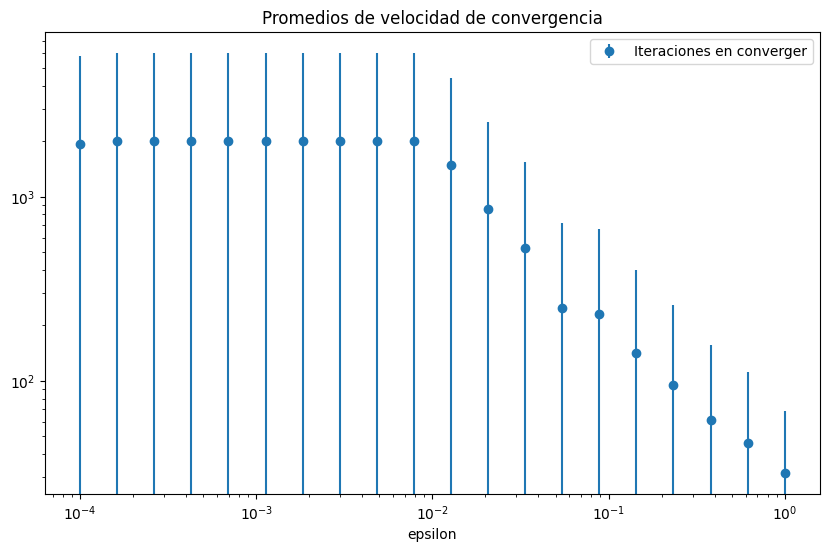

In [82]:
tolerancia = 10e-7
niter = 10000

convergencias = []
desvios = []
escala_eps = np.logspace(-4, 0, 20)

for epsilon in escala_eps:
    D = np.diag([10, 10-epsilon, 5, 2, 1]).astype(np.float64)
    v = 40*np.random.randn(D.shape[0], 1)
    v = v / np.linalg.norm(v)
    B = np.eye(D.shape[0]) - 2 * (v @ v.T) # Matriz de Householder
    # M semejante a D --> los valores de la diaginal D son los autovalores de M
    M = B.T @ D @ B 

    res = TP2Metodos.eigen_convergence(M, niter, tolerancia)
    velocidades = res[2][0]
    promedio_convergencia = np.mean(velocidades)
    desvio = np.std(velocidades)
    convergencias.append(promedio_convergencia)
    desvios.append(desvio)


plt.figure(figsize=(10, 6))
plt.errorbar(escala_eps, convergencias, yerr=desvios, fmt='o', label='Iteraciones en converger')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('epsilon')
plt.title('Promedios de velocidad de convergencia')
plt.legend()
plt.show()

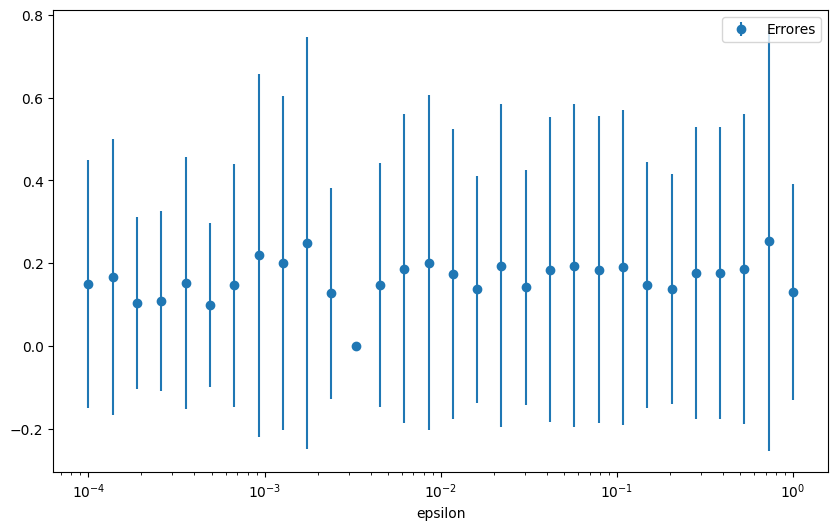

In [50]:
tolerancia = 10e-7
niter = 10000

erroresTotal = []
desvios = []
escala_eps = np.logspace(-4, 0, 30)

for epsilon in escala_eps:
    D = np.diag([10, 10-epsilon, 5, 2, 1]).astype(np.float64)
    v = 50*np.random.randn(D.shape[0], 1)
    v = v / np.linalg.norm(v)
    B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    M = B.T @ D @ B 

    res = TP2Metodos.eigen_convergence(M, niter, tolerancia)
    errores = res[2][1]
    promedio_error = np.mean(errores)
    desvio = np.std(errores)

    erroresTotal.append(promedio_error)
    desvios.append(desvio)


plt.figure(figsize=(10, 6))
plt.errorbar(escala_eps, erroresTotal, yerr=desvios, fmt='o', label='Errores')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('epsilon')
plt.legend()
plt.show()

# PCA

In [83]:
niter = 100000
tolerancia = 10e-7

def pca(X):
    Cov = X.T @ X
    n = Cov.shape[0]
    Cov = Cov / (n-1)

    eigen = TP2Metodos.eigen_convergence(Cov, niter, tolerancia)
    autovalores = eigen[0]
    autovectores = eigen[1]

    return autovectores, autovalores

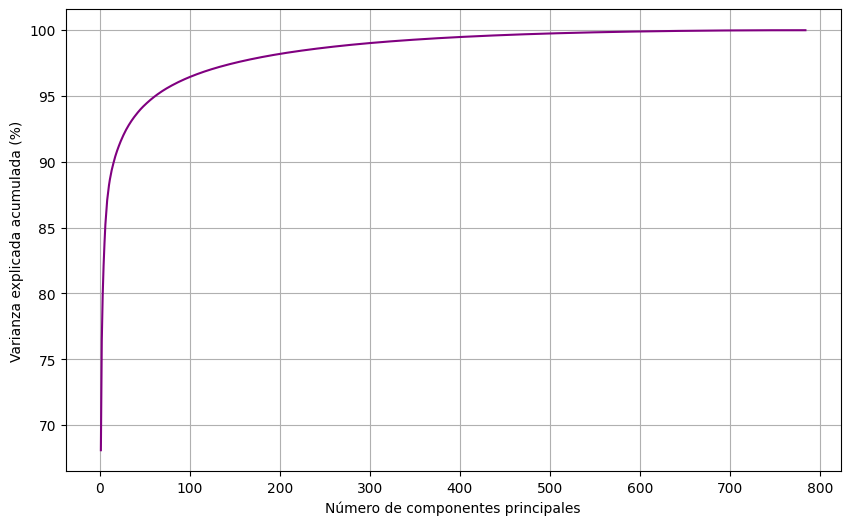

In [30]:
(V, varianzas) = pca(X_train)

#no lo ordenamos ya que vienen ordenados gracias al metodo de la potencia.
#igual dejamos comentado el codigo que lo ordena 
#indicesVarianzas = np.argsort(varianzas)[::-1] #ordenamos de mayor a menor
#varianzas = varianzas[indicesVarianzas]
#Vord = V[:, indicesVarianzas]

varianzaExplicada = varianzas / np.sum(V)
varianzaAcumulada = np.cumsum(varianzaExplicada)

varianzaAcumulada = varianzaAcumulada / np.max(varianzaAcumulada)
varianzaAcumulada *= 100

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(varianzaExplicada) + 1), varianzaAcumulada, linestyle='-', color='purple')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada (%)')
plt.grid(True)
plt.show()

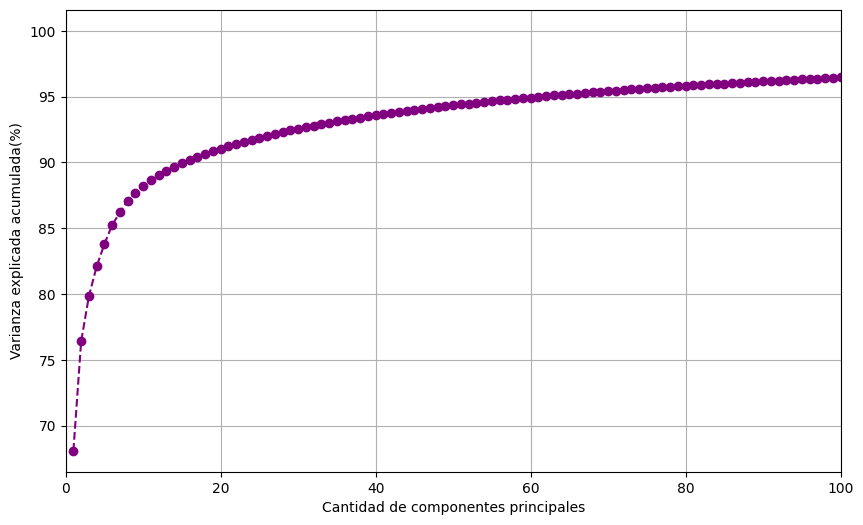

In [76]:
#Veamos la zona significativa en el grafico

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(varianzaExplicada) + 1), varianzaAcumulada, marker='o', linestyle='--', color='purple')
plt.xlabel('Cantidad de componentes principales')
plt.ylabel('Varianza explicada acumulada(%)')

plt.xlim(0, 100)
plt.grid(True)



plt.show()

Nos quedamos con los mejores parámetros de p y k en base a la exactitud
k*, p* = max k,p en base a exactitud 

Calcular exactitud final con k*, p*, train completo, datos de prueba, hacer devuelta PCA

In [19]:
# cross validation pero no hacemos adentro knn
def fiveFoldCrossValidation(x_train, y_train, i):     # i = componente a ser dev, f = cantidad de folds
    
    x_split = np.split(x_train, 5) 
    y_split = np.split(y_train, 5) 
    
    x_current_dev = x_split[i]
    y_current_dev = y_split[i]
    
    x_split.pop(i)
    y_split.pop(i)
    x_current_train = np.concatenate(x_split, axis = 0)
    y_current_train = np.concatenate(y_split, axis = 0)
    
    return x_current_train, y_current_train, x_current_dev, y_current_dev

In [20]:
pcaCache = {}

def pcaWrapper(x, i):
    res = False
    try: 
        res = pcaCache[i]
    except KeyError:
        res = pca(x) 
        pcaCache[i] = res
    
    return res

In [25]:
#precomputamos PCA
for i in range(0,5):
    (x_current_train, y_current_train, x_current_dev, y_current_dev) = fiveFoldCrossValidation(X_train, y_train, i)
    pcaWrapper(x_current_train, i)

In [32]:
# La exactitud es basicamente hacer knn
def exactitud(X_train, y_train, X_dev, y_dev, k):
    return kNearestNeighbour(X_train, y_train, X_dev, y_dev, k) 

def eleccionParametros(X_train, y_train, kMax, pMax):  # exploramos del rango (0, k) y (0, p)
    resultados = {}               # Definimos un diccionario para guardar las exactitudes para cada par (k, p). Estas serán las keys, sus valores listas con las exactitudes.
    
    log_scale_values = np.logspace(start = 1, stop = np.log10(pMax), num=20)
    escala_log_p = np.round(log_scale_values).astype(int)
    
    # Inicializo todas las claves, con listas vacías como valores
    for k in range(1, kMax+1):
        for p in escala_log_p:
            resultados[(k, p)] = []

    # Defino las listas con los valores para cada partición
    for i in range(0,5):
        
        (x_current_train, y_current_train, x_current_dev, y_current_dev) = fiveFoldCrossValidation(X_train, y_train, i)
        
        (V, a) = pcaWrapper(x_current_train, i)         # El a son los autovalores, no lo usamos en este caso.
        
        for k in range(1, kMax + 1):
            for p in escala_log_p:
                x_train_pca = x_current_train @ (V[:, :p])                 # Usamos las primeras p componentes de V 
                X_dev_pca = x_current_dev @ (V[:, :p])
                
                exa = exactitud(x_train_pca, y_current_train, X_dev_pca, y_current_dev, k)
                resultados[(k, p)].append(exa)
    
    
    #Promedio para cada combinacion de p y k
    maximo = -1 
    for k_p in resultados:
        exa = sum(resultados[k_p]) / 5
        if exa > maximo:
            maximo = exa 
            k_p_star = k_p

    return k_p_star, resultados

In [84]:
parametros = eleccionParametros(X_train, y_train, 20, 200)

hiperP = parametros[0][1]
hiperK = parametros[0][0]

print('Los hiperparametros optimos son:', parametros[0])

Los hiperparametros optimos son: (4, 57)


Distribucion de los parametros en el plano

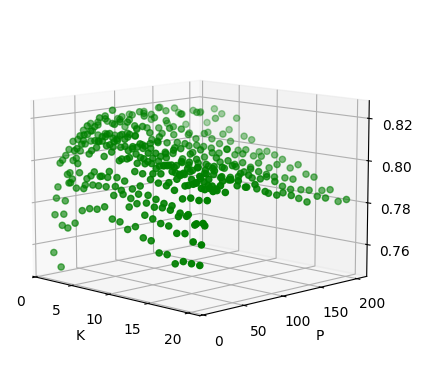

In [66]:
k_values = []
p_values = []
averages = []
for (k, p), values in parametros[1].items():
    k_values.append(k)
    p_values.append(p)
    averages.append(np.mean(values))
k_values = np.array(k_values)
p_values = np.array(p_values)
averages = np.array(averages)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(k_values, p_values, averages, c='green', marker='o')

ax.set_xlabel('K')
ax.set_ylabel('P')
ax.set_zlabel('Promedio')

elev = 10  # ángulo de elevación
azim = 315  # ángulo de rotación
ax.view_init(elev=elev, azim=azim)

plt.show()

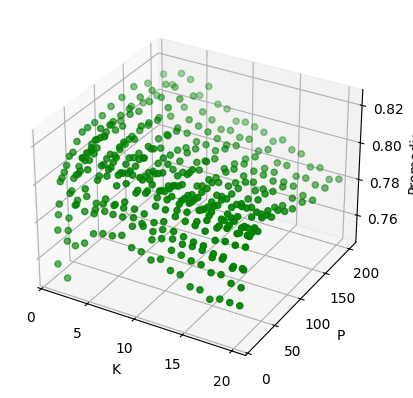

In [65]:
#angulo generico
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(k_values, p_values, averages, c='green', marker='o')

ax.set_xlabel('K')
ax.set_ylabel('P')
ax.set_zlabel('Promedio')

plt.show()

Ya conociendo los hiperparametros k y p optimos entrenemos con esto

In [71]:
def reconocedor(X_train, y_train, X_test, y_test, k, p):
    (V, a) = pca(X_train)
    X_newtrain = X_train @ (V[:, :p])
    X_newtest = X_test @ (V[:, :p])

    return exactitud(X_newtrain, y_train, X_newtest, y_test, k)

In [72]:
reconocedor(X_train, y_train, X_test, y_test, hiperK, hiperP)

0.84